In [1]:
import pandas as pd

train_df = pd.read_csv("large_train_entropy.csv")

# Combine into one dataframe
df = train_df

print(df.shape)  # check total rows

(9939, 12)


In [2]:
import torch

train_emb = torch.load("large_patch_train_embeddings.pt", weights_only=False)

In [4]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Feature columns
feature_cols = [
    "text1_mean_entropy", "text1_sum_entropy", "text1_n_tokens",
    "text2_mean_entropy", "text2_sum_entropy", "text2_n_tokens",
    "delta_mean_entropy", "delta_sum_entropy", "delta_n_tokens"
]

X = df[feature_cols]
y = df["label"]

# Split into train/test sets
X_train, X_test, y_train, y_test, emb_train, emb_test = train_test_split(
    X, y, train_emb,
    test_size=0.2,   # 20% test
    stratify=y,      # keep class balance
    random_state=42
)

print(X_train.shape, X_test.shape)
print(emb_train.shape, emb_test.shape)

params = {
    "objective": "binary",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 1000
}

# Define model
model = LGBMClassifier(
    **params
)

print("Training LightGBM model...")
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)
    ]
)

# Evaluate
y_pred = model.predict_proba(X_test)[:, 1]
y_pred_labels = (y_pred > 0.5).astype(int)

print("\nClassification report:")
print(classification_report(y_test, y_pred_labels))
print("\nROC-AUC:", roc_auc_score(y_test, y_pred))

(7951, 9) (1988, 9)
torch.Size([7951, 3072]) torch.Size([1988, 3072])
Training LightGBM model...
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 3857, number of negative: 4094
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true

In [ ]:
# import optuna
# from lightgbm import LGBMClassifier, early_stopping, log_evaluation
# from sklearn.metrics import roc_auc_score, classification_report
#
#
# def objective(trial):
#     # --- Suggest hyperparameters ---
#     param = {
#         "objective": "binary",
#         "boosting_type": "gbdt",
#         "n_estimators": 1000,
#         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 0.3),
#         "num_leaves": trial.suggest_int("num_leaves", 16, 256),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.6, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.6, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
#         "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
#     }
#
#     # --- Train model ---
#     model = LGBMClassifier(**param, verbosity=-1)
#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_test, y_test)],
#         eval_metric="auc",
#         callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=0)],
#     )
#
#     # --- Evaluate ---
#     y_pred = model.predict_proba(X_test)[:, 1]
#     auc = roc_auc_score(y_test, y_pred)
#
#     return auc  # Optuna tries to maximize this
#
#
# # --- Run study ---
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=50)
#
# print("\nBest trial:")
# trial = study.best_trial
# print(f"AUC: {trial.value}")
# print("Best hyperparameters:", trial.params)
#
# # --- Retrain final model with best params ---
# best_model = LGBMClassifier(**trial.params)
# best_model.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)],
#     eval_metric="auc",
#     callbacks=[early_stopping(stopping_rounds=50), log_evaluation(period=50)]
# )

In [ ]:
# import numpy as np

# y_shuffled = np.random.permutation(y)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y_shuffled, stratify=y_shuffled, test_size=0.2, random_state=42
# )

# model.fit(X_train, y_train)
# print("ROC-AUC with shuffled labels:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


In [5]:
print(df[feature_cols + ["label"]].corr()["label"].sort_values())

delta_mean_entropy   -0.493198
text1_mean_entropy   -0.255950
text2_mean_entropy   -0.023161
delta_sum_entropy     0.403390
text2_n_tokens        0.420588
delta_n_tokens        0.518037
text2_sum_entropy     0.533338
text1_n_tokens        0.574854
text1_sum_entropy     0.617135
label                 1.000000
Name: label, dtype: float64


In [32]:
# from sklearn.model_selection import StratifiedKFold, cross_val_score

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc")
# print("CV ROC-AUC scores:", scores)
# print("Mean:", scores.mean(), "Std:", scores.std())

In [6]:
import numpy as np
from sklearn.model_selection import KFold
import lightgbm as lgb

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

oof_probs = np.zeros(len(y_train))
# optionally store per-fold temperature params if you do temp scaling per fold

for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    model = lgb.LGBMClassifier(**params, verbosity=-1)
    model.fit(X_tr, y_tr)

    oof_probs[val_idx] = model.predict_proba(X_val)[:, 1]

In [7]:
print("\nROC-AUC:", roc_auc_score(y_train, oof_probs))


ROC-AUC: 0.9693763830258563


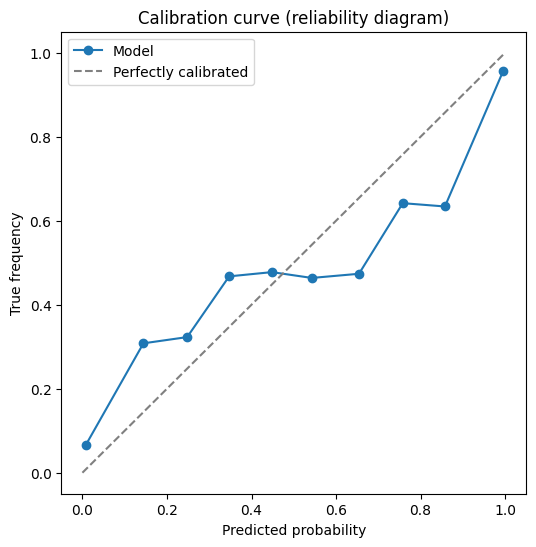

Brier score: 0.0711219623113259


In [8]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_train, oof_probs, n_bins=10, strategy="uniform")

# plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.title("Calibration curve (reliability diagram)")
plt.legend()
plt.show()

# also check Brier score
brier = brier_score_loss(y_train, oof_probs)
print("Brier score:", brier)

In [9]:
import numpy as np

def compute_ece(y_true, y_prob, n_bins=10):
    bins = np.linspace(0, 1, n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        mask = (y_prob > bins[i]) & (y_prob <= bins[i+1])
        if np.any(mask):
            bin_acc = y_true[mask].mean()
            bin_conf = y_prob[mask].mean()
            ece += np.abs(bin_conf - bin_acc) * mask.mean()
    return ece

ece = compute_ece(y_train, oof_probs)
print("Expected Calibration Error (ECE):", ece)

Expected Calibration Error (ECE): 0.056740019553954704


In [10]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# Fit a single-parameter logistic (temperature) on a validation set
logit_probs = np.log(oof_probs / (1 - oof_probs))  # logit transform
temp_model = LogisticRegression(fit_intercept=False)
temp_model.fit(logit_probs.reshape(-1,1), y_train)

# Adjusted probabilities
logit_probs_test = np.log(oof_probs / (1 - oof_probs))
scaled_probs = 1 / (1 + np.exp(-temp_model.coef_[0][0] * logit_probs_test))

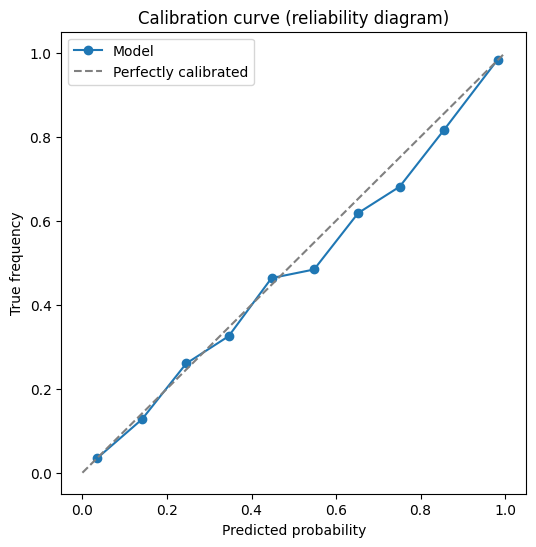

Brier score: 0.0711219623113259


In [11]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# compute calibration curve
prob_true, prob_pred = calibration_curve(y_train, scaled_probs, n_bins=10, strategy="uniform")

# plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True frequency")
plt.title("Calibration curve (reliability diagram)")
plt.legend()
plt.show()

# also check Brier score
brier = brier_score_loss(y_train, oof_probs)
print("Brier score:", brier)

In [12]:
emb_train_np = emb_train.cpu().numpy().astype('float32')

In [14]:
import faiss

faiss.normalize_L2(emb_train_np)  # in-place normalization

In [15]:
import numpy as np

# check L2 norms
np.linalg.norm(emb_train_np, axis=1)  # should be very close to 1 for all rows

array([0.99999994, 0.9999997 , 0.9999999 , ..., 0.9999999 , 0.9999999 ,
       0.9999997 ], shape=(7951,), dtype=float32)

In [16]:
d = emb_train_np.shape[1]  # embedding dimension
index = faiss.IndexFlatIP(d)  # inner product index (cosine after normalization)
index = faiss.IndexIDMap(index)
ids = np.arange(len(emb_train_np))
index.add_with_ids(emb_train_np, ids)

In [17]:
faiss.write_index(index, "local_index.faiss")
# Later
index = faiss.read_index("local_index.faiss")

In [18]:
import numpy as np
import faiss

def search_neighbors(query_emb, index, preds, k=5):
    # Copy to avoid modifying the original
    q = query_emb.cpu().numpy().astype("float32").reshape(1, -1)
    faiss.normalize_L2(q)
    D, I = index.search(q, k)

    return np.array(D), np.array(I), np.array(preds[I])

In [61]:
from tqdm import tqdm

results = {}

for i, emb in enumerate(tqdm(emb_test, desc="Searching neighbors")):
    sim, ids, probs = search_neighbors(emb, index, scaled_probs, 5)
    
    results[i] = {
        "neighbor_sim": sim,
        "neighbor_ids": ids,
        "neighbor_probs": probs,
        "pred_prob": y_pred[i],  # predicted probability for this sample
        "true_pred": y_test.iloc[i]
    }

Searching neighbors: 100%|██████████| 1988/1988 [00:12<00:00, 153.73it/s]


In [141]:
print(results[0])

{'neighbor_sim': array([[0.8913682, 0.8831325, 0.8820458, 0.8695147, 0.8676532]],
      dtype=float32), 'neighbor_ids': array([[5152, 1579, 3060, 5677, 5173]]), 'neighbor_probs': array([[0.05210916, 0.05483369, 0.10199738, 0.05690058, 0.09865369]]), 'pred_prob': np.float64(0.008192860939089061), 'true_pred': np.int64(0)}


In [63]:
errors = []
for i, entry in results.items():
    true_label = y_test.iloc[i]
    pred_prob = entry["pred_prob"]
    pred_class = int(pred_prob > 0.5)
    if pred_class != true_label:
        errors.append(i)

print(f"Total errors: {len(errors)} / {len(y_test)}")

Total errors: 155 / 1988


In [64]:
error_stats = []
for i in errors:
    entry = results[i]
    p = entry["pred_prob"]
    neigh_p = entry["neighbor_probs"].ravel()
    sims = entry["neighbor_sim"].ravel()
    neighbor_var = np.var(neigh_p)
    
    error_stats.append({
        "index": i,
        "true": y_test.iloc[i],
        "pred_prob": p,
        "neighbor_var": neighbor_var
    })


In [65]:
for i in errors[:5]:
    entry = results[i]
    print(f"Index {i}, true {y_test.iloc[i]}, pred {entry['pred_prob']:.3f}")
    print("Top-k neighbor probs:", entry["neighbor_probs"].ravel())
    print("Top-k similarities:", entry["neighbor_sim"].ravel())

Index 14, true 1, pred 0.215
Top-k neighbor probs: [0.36950089 0.27953154 0.60354481 0.20636263 0.09416138]
Top-k similarities: [0.99041903 0.98958826 0.9842151  0.9817933  0.981467  ]
Index 16, true 0, pred 0.706
Top-k neighbor probs: [0.27806374 0.02821296 0.32144661 0.06306101 0.03425252]
Top-k similarities: [0.8586177  0.8507558  0.84813327 0.84209156 0.8377588 ]
Index 22, true 0, pred 0.643
Top-k neighbor probs: [0.01984231 0.05202275 0.93472081 0.07457155 0.98928629]
Top-k similarities: [0.83798134 0.8327428  0.83171695 0.83017105 0.83013463]
Index 34, true 1, pred 0.375
Top-k neighbor probs: [0.22549432 0.10114593 0.96435557 0.10171996 0.99033888]
Top-k similarities: [0.99102557 0.9821891  0.96033114 0.95147806 0.9444541 ]
Index 39, true 1, pred 0.327
Top-k neighbor probs: [0.06549711 0.9990149  0.97531398 0.00736778 0.99469351]
Top-k similarities: [0.95580316 0.94501567 0.9449735  0.9443237  0.9436873 ]


In [24]:
import numpy as np

irreducible_errors = []

for i in errors:  # errors = indices where model prediction != y_test
    entry = results[i]
    pred_label = int(entry['pred_prob'] > 0.5)
    neigh_labels = (entry['neighbor_probs'].ravel() > 0.5).astype(int)
    
    # Count neighbors agreeing with the model prediction
    agree_count = np.sum(neigh_labels == pred_label)
    
    if agree_count >= 4:  # 80% agreement
        irreducible_errors.append(i)

print(f"Total errors: {len(errors)}")
print(f"Irreducible errors (>=4 neighbors agree with wrong prediction): {len(irreducible_errors)}")
print("Indices of irreducible errors:", irreducible_errors)

Total errors: 155
Irreducible errors (>=4 neighbors agree with wrong prediction): 17
Indices of irreducible errors: [14, 142, 174, 184, 322, 411, 573, 709, 832, 871, 1052, 1165, 1438, 1580, 1631, 1641, 1651]


In [121]:
import numpy as np

def ss_weighted(p, neigh_p, sims):
    return 1.0 - (np.sum(sims * np.abs(neigh_p - p)) / np.sum(sims))

def cp_soft(p, neigh_p, sims):
    p_opp = 1.0 - p
    neigh_opp = 1.0 - neigh_p
    diffs = neigh_opp - p_opp  # positive → neighbor favors opposite more
    pos = diffs[diffs > 0]
    sims_pos = sims[diffs > 0]
    return float((sims_pos * pos).max()) if pos.size else 0.0

def neighbor_mean_prob(neigh_p, sims=None):
    if sims is not None:
        return np.sum(neigh_p * sims) / np.sum(sims)  # similarity-weighted
    else:
        return np.mean(neigh_p)

def fi_additive(SS, CP, alpha=0.5):
    FI = alpha * (1 - SS) + (1 - alpha) * CP
    return np.clip(FI, 0.0, 1.0)


In [135]:
from tqdm import tqdm

# New dict to store the scores and adjusted probabilities
scores_dict = {}

for i in tqdm(results.keys(), desc="Computing soft scores"):
    entry = results[i]
    
    p = entry["pred_prob"]                  # original model probability
    neigh_p = entry["neighbor_probs"].ravel()
    sims = entry["neighbor_sim"].ravel()
    
    # Compute soft metrics
    SS = ss_weighted(p, neigh_p, sims)
    CP = cp_soft(p, neigh_p, sims)
    FI = fi_additive(SS, CP)
    NM = neighbor_mean_prob(neigh_p, sims)

    adjusted_prob = p * (1 - FI) + NM * FI
    
    scores_dict[i] = {
        "SS_soft": SS,
        "CP_soft": CP,
        "FI_soft": FI,
        "model_class": p,
        "adjusted_prob": adjusted_prob,
        "true_class": entry["true_pred"]
    }

Computing soft scores: 100%|██████████| 1988/1988 [00:00<00:00, 28386.88it/s]


In [142]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# ---- Extract arrays from scores_dict ----
indices = list(scores_dict.keys())

SS_arr = np.array([scores_dict[i]["SS_soft"] for i in indices])
CP_arr = np.array([scores_dict[i]["CP_soft"] for i in indices])
model_prob = np.array([scores_dict[i]["model_class"] for i in indices])  # raw model prob
true_class = np.array([scores_dict[i]["true_class"] for i in indices])

# Predicted class labels
y_pred = (model_prob > 0.5).astype(int)

# ---- Selective filter ----
def selective_accept_margin(SS, CP, model_prob, t, c, min_margin):
    strong_conf = np.abs(model_prob - 0.5) >= min_margin
    return ((SS >= t) & (CP <= c)) | strong_conf

# ---- Evaluation function ----
def evaluate_gate(SS, CP, model_prob, y_true, y_pred, t, c, min_margin, lam=0.8):
    accepted = selective_accept_margin(SS, CP, model_prob, t, c, min_margin)

    # False Accept = error slips through
    FA = np.sum((y_pred != y_true) & accepted)
    # False Reject = correct prediction flagged unnecessarily
    FR = np.sum((y_pred == y_true) & ~accepted)

    FA_rate = FA / np.sum(y_pred != y_true) if np.sum(y_pred != y_true) > 0 else 0.0
    FR_rate = FR / np.sum(y_pred == y_true) if np.sum(y_pred == y_true) > 0 else 0.0

    # Weighted score
    score = lam * FA_rate + (1 - lam) * FR_rate

    # Extra diagnostics
    llm_usage_rate = np.mean(~accepted)
    residual_error_rate = np.mean((y_pred != y_true) & accepted)

    return score, FA_rate, FR_rate, llm_usage_rate, residual_error_rate

# ---- Grid search ----
best = None
for t in np.linspace(0.5, 0.9, 5):
    for c in np.linspace(0.05, 0.3, 6):
        for m in np.linspace(0.1, 0.4, 4):
            score, fa, fr, llm_usage, res_err = evaluate_gate(
                SS_arr, CP_arr, model_prob, true_class, y_pred, t, c, m, lam=0.8
            )
            if best is None or score < best["score"]:
                best = {
                    "score": score,
                    "t": t,
                    "c": c,
                    "min_margin": m,
                    "FA_rate": fa,
                    "FR_rate": fr,
                    "LLM_usage_rate": llm_usage,
                    "Residual_error_rate": res_err
                }

# ---- Print results nicely ----
print("=== Best Threshold Configuration ===")
print(f"  SS threshold (t):       {best['t']:.2f}")
print(f"  CP threshold (c):       {best['c']:.2f}")
print(f"  Min margin:             {best['min_margin']:.2f}")
print("\n=== Performance ===")
print(f"  Weighted score:         {best['score']:.3f}")
print(f"  False Accept rate:      {best['FA_rate']:.3f}")
print(f"  False Reject rate:      {best['FR_rate']:.3f}")
print(f"  LLM usage rate:         {best['LLM_usage_rate']:.3f}")
print(f"  Residual error rate:    {best['Residual_error_rate']:.3f}")


=== Best Threshold Configuration ===
  SS threshold (t):       0.90
  CP threshold (c):       0.20
  Min margin:             0.40

=== Performance ===
  Weighted score:         0.237
  False Accept rate:      0.258
  False Reject rate:      0.152
  LLM usage rate:         0.198
  Residual error rate:    0.020


In [123]:
scores_dict

{0: {'SS_soft': np.float64(0.9353812773814498),
  'CP_soft': 0.0,
  'FI_soft': np.float64(0.032309361309275086),
  'model_class': np.float64(0.008192860939089061),
  'adjusted_prob': np.float64(0.010280650595515625),
  'use_llm': False,
  'true_class': np.int64(0)},
 1: {'SS_soft': np.float64(0.9939023031806381),
  'CP_soft': 0.009497617536845618,
  'FI_soft': np.float64(0.007797657178103758),
  'model_class': np.float64(0.9991165569254401),
  'adjusted_prob': np.float64(0.9990690094648821),
  'use_llm': False,
  'true_class': np.int64(1)},
 2: {'SS_soft': np.float64(0.9940231527487198),
  'CP_soft': 0.00865801034506935,
  'FI_soft': np.float64(0.007317428798174788),
  'model_class': np.float64(0.9984287909051096),
  'adjusted_prob': np.float64(0.9983850561129897),
  'use_llm': False,
  'true_class': np.int64(1)},
 3: {'SS_soft': np.float64(0.7704090216567638),
  'CP_soft': 0.0,
  'FI_soft': np.float64(0.11479548917161808),
  'model_class': np.float64(0.0054112673616770295),
  'adjuste

In [124]:
from collections import Counter

counts = Counter()

for entry in scores_dict.values():
    adj_pred = int(entry["adjusted_prob"] > 0.5)
    true_class = entry["true_class"]
    use_llm = entry["use_llm"]

    if use_llm and adj_pred != true_class:
        counts["llm_used_on_error"] += 1        # correctly flagged
    elif use_llm and adj_pred == true_class:
        counts["llm_used_unneeded"] += 1       # flagged but actually correct
    elif not use_llm and adj_pred != true_class:
        counts["llm_missed_error"] += 1        # missed opportunity
    else:
        counts["llm_correct_no_llm"] += 1      # correct and not flagged

print(counts)

Counter({'llm_correct_no_llm': 1714, 'llm_used_unneeded': 169, 'llm_used_on_error': 59, 'llm_missed_error': 46})


In [125]:
from collections import Counter

# Assume `irreducible_errors` is defined as you did
llm_stats = Counter({
    "llm_used_on_irreducible": 0,
    "llm_missed_irreducible": 0,
    "llm_used_on_fixable": 0,
    "llm_missed_fixable": 0
})

for entry_id, entry in scores_dict.items():
    adj_pred = int(entry["adjusted_prob"] > 0.5)
    true_class = entry["true_class"]
    use_llm = entry["use_llm"]
    
    is_error = adj_pred != true_class
    is_irreducible = entry_id in irreducible_errors
    
    if use_llm and is_error:
        if is_irreducible:
            llm_stats["llm_used_on_irreducible"] += 1
        else:
            llm_stats["llm_used_on_fixable"] += 1
    elif not use_llm and is_error:
        if is_irreducible:
            llm_stats["llm_missed_irreducible"] += 1
        else:
            llm_stats["llm_missed_fixable"] += 1

print(llm_stats)


Counter({'llm_used_on_fixable': 53, 'llm_missed_fixable': 35, 'llm_missed_irreducible': 11, 'llm_used_on_irreducible': 6})


In [126]:
import numpy as np
from sklearn.metrics import classification_report

# Prepare new predictions
y_pred_new = []

for i in range(len(y_test)):
    ap = scores_dict[i]['adjusted_prob']
    
    y_pred_new.append(ap)

y_pred_new = np.array(y_pred_new)

# Compute classification report
print("\nROC-AUC:", roc_auc_score(y_test, y_pred_new))


ROC-AUC: 0.9876369618775934


In [127]:
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score

# Original binary predictions
y_pred_orig = (y_pred > 0.5).astype(int)

# New binary predictions after selective adjustment
y_pred_new_labels = (y_pred_new > 0.5).astype(int)

# Compute number of samples that were corrected
corrected_mask = (y_pred_orig != y_test.values) & (y_pred_new_labels == y_test.values)
num_corrected = np.sum(corrected_mask)
total_errors = np.sum(y_pred_orig != y_test.values)

print(f"Total original errors: {total_errors}")
print(f"Errors corrected by selective adjustment: {num_corrected}")
print(f"Percentage corrected: {100 * num_corrected / total_errors:.2f}%")

# Optionally, show new classification report
print("\nClassification report after selective adjustment:")
print(classification_report(y_test, y_pred_new_labels))

# ROC-AUC
print("\nROC-AUC after adjustment:", roc_auc_score(y_test, y_pred_new))

Total original errors: 155
Errors corrected by selective adjustment: 60
Percentage corrected: 38.71%

Classification report after selective adjustment:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1024
           1       0.98      0.91      0.94       964

    accuracy                           0.95      1988
   macro avg       0.95      0.95      0.95      1988
weighted avg       0.95      0.95      0.95      1988


ROC-AUC after adjustment: 0.9876369618775934


In [128]:
irreducible_corrected = [i for i in irreducible_errors if i in np.where(corrected_mask)[0]]

print(f"Number of irreducible errors corrected: {len(irreducible_corrected)}")
print("Indices:", irreducible_corrected)

Number of irreducible errors corrected: 0
Indices: []


In [129]:
# Mask for errors that were not corrected
uncorrected_mask = (y_pred_orig != y_test.values) & (y_pred_new_labels != y_test.values)
num_uncorrected = np.sum(uncorrected_mask)

print(f"Errors not corrected by selective adjustment: {num_uncorrected}")
print(f"Percentage of original errors still wrong: {100 * num_uncorrected / total_errors:.2f}%")

Errors not corrected by selective adjustment: 95
Percentage of original errors still wrong: 61.29%


In [130]:
# irreducible_errors = indices where >=4 neighbors agree with wrong prediction
# errors = all indices where model prediction != true label

# Keep only errors that are NOT irreducible
analyzable_errors = [i for i in errors if i not in irreducible_errors]

print(f"Total errors: {len(errors)}")
print(f"Irreducible errors: {len(irreducible_errors)}")
print(f"Errors we can analyze (non-irreducible): {len(analyzable_errors)}")

Total errors: 155
Irreducible errors: 17
Errors we can analyze (non-irreducible): 138


In [131]:
uncorrected_analyzable = [i for i in analyzable_errors if uncorrected_mask[i]]

print(f"Analyzable errors still uncorrected: {len(uncorrected_analyzable)}")

Analyzable errors still uncorrected: 78


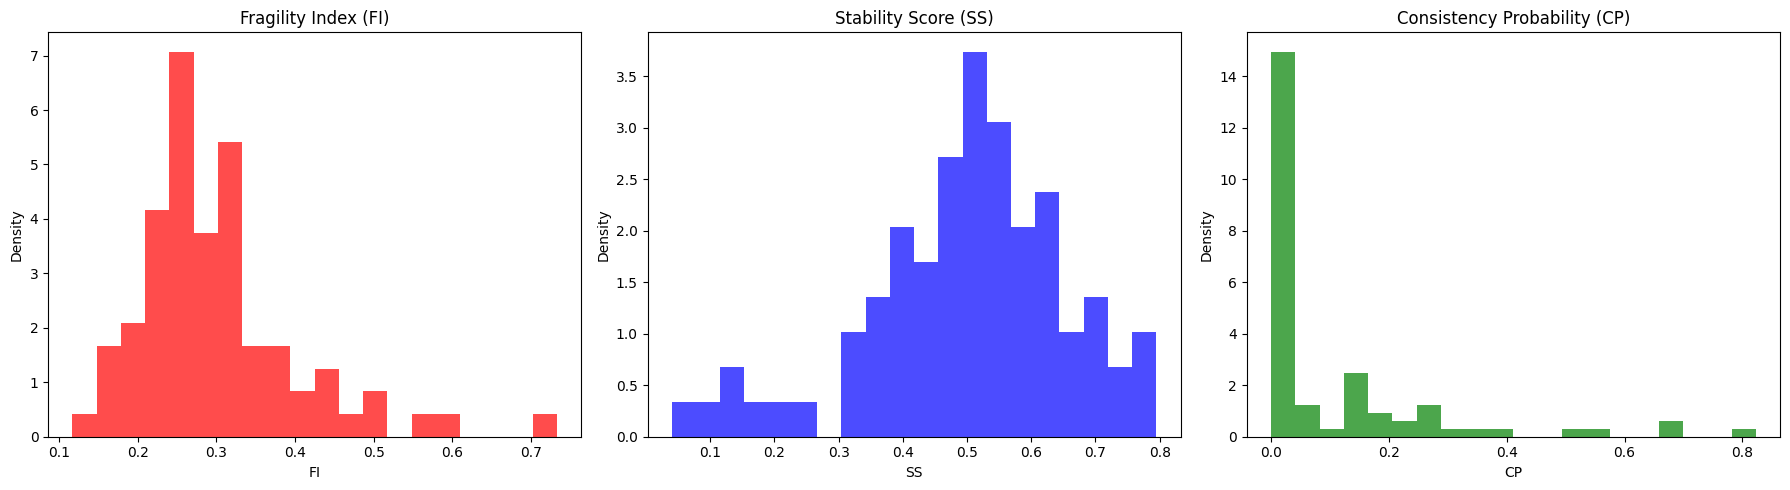

In [132]:
# Extract scores for uncorrected & analyzable errors
FI_scores = [scores_dict[i]["FI_soft"] for i in uncorrected_analyzable]
SS_scores = [scores_dict[i]["SS_soft"] for i in uncorrected_analyzable]
CP_scores = [scores_dict[i]["CP_soft"] for i in uncorrected_analyzable]

# Create a figure with 3 subplots in one row
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Fragility Index
axes[0].hist(FI_scores, bins=20, alpha=0.7, color="red", density=True)
axes[0].set_xlabel("FI")
axes[0].set_ylabel("Density")
axes[0].set_title("Fragility Index (FI)")

# Stability Score
axes[1].hist(SS_scores, bins=20, alpha=0.7, color="blue", density=True)
axes[1].set_xlabel("SS")
axes[1].set_ylabel("Density")
axes[1].set_title("Stability Score (SS)")

# Consistency Probability
axes[2].hist(CP_scores, bins=20, alpha=0.7, color="green", density=True)
axes[2].set_xlabel("CP")
axes[2].set_ylabel("Density")
axes[2].set_title("Consistency Probability (CP)")

plt.tight_layout()
plt.show()

In [133]:
import numpy as np

# Convert scores to numpy arrays
FI = np.array(FI_scores)
SS = np.array(SS_scores)
indices = np.array(uncorrected_analyzable)  # indices in full test set

# Mask for FI=0 and SS<0.3
mask = SS < 0.3

# Corresponding indices in the full test set
selected_indices = indices[mask]

# Get full-model predictions and true labels for these errors
pred_probs_selected = y_pred[selected_indices]          # probabilities
pred_labels_selected = (pred_probs_selected > 0.5).astype(int)
true_labels_selected = y_test.values[selected_indices]

print("Number of FI=0 & SS<0.3 errors:", len(selected_indices))
print("Predicted probabilities:", pred_probs_selected)
print("Predicted labels:", pred_labels_selected)
print("True labels:", true_labels_selected)

Number of FI=0 & SS<0.3 errors: 7
Predicted probabilities: [0.17568502 0.08518013 0.01810967 0.04629902 0.18164346 0.00974868
 0.02684858]
Predicted labels: [0 0 0 0 0 0 0]
True labels: [1 1 1 1 1 1 1]


In [48]:
import pandas as pd

df_scores = pd.DataFrame({
    "FI": FI_scores,
    "SS": SS_scores,
    "CP": CP_scores
})

print(df_scores.corr())

          FI        SS        CP
FI  1.000000 -0.239304  0.976909
SS -0.239304  1.000000 -0.120202
CP  0.976909 -0.120202  1.000000


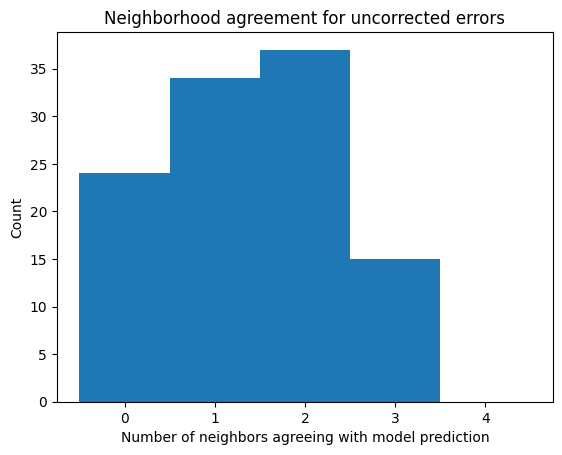

In [43]:
neighbor_agreement = []
for i in uncorrected_analyzable:
    pred_label = int(results[i]['pred_prob'] > 0.5)
    neigh_labels = (results[i]['neighbor_probs'].ravel() > 0.5).astype(int)
    neighbor_agreement.append(np.sum(neigh_labels == pred_label))

plt.hist(neighbor_agreement, bins=range(6), align='left')
plt.xlabel("Number of neighbors agreeing with model prediction")
plt.ylabel("Count")
plt.title("Neighborhood agreement for uncorrected errors")
plt.show()